# Figure 12: Throughput

This code is used to create **Figure 12** in the **Apples with Apples** paper [(Bonse et al. 2023)](../../05_citation.rst). The code shows how to compute a throughput table which presents the amount of signal loss due to PCA.'

## Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast
from applefy.detections.contrast import ContrastResult
from applefy.utils.photometry import AperturePhotometryMode
from applefy.utils.file_handling import read_apples_with_apples_root, load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio
from applefy.utils.positions import center_subpixel

## Data Loading

Figure 12 runs several fake planet experiments on the unstacked NACO data (see details in the paper). In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir


The HR (High Temporal Resolution) data is the unstacked NACO data. Calculations with this data can be **computationally intensive**. You can also run the code with the LR (Low Temporal Resolution) data to save time.

In [3]:
# 30_data/betapic_naco_lp_LR
dataset_file = experiment_root / Path("30_data/betapic_naco_lp_HR.hdf5")
science_data_key = "science_no_planet"
psf_template_key = "psf_template"
parang_key = "header_science_no_planet/PARANG"

dit_psf_template = 0.02019
dit_science = 0.2
fwhm = 4.2  # estimeated with Pynpoint in advance

We load the unstacked NACO data. In order to save computation time we reduce the resolution of the science sequence by cutting around the central star.

In [4]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag=science_data_key,
    psf_template_tag=psf_template_key,
    para_tag=parang_key)

psf_template = raw_psf_template_data[82:-82, 82:-82]
science_data = science_data[:, 55:-55, 55:-55]

## Compute the Throughput Table

We use the class [Contrast](../../03_package/detections.rst#applefy.detections.contrast.Contrast) of applefy to calculate the throughput table. The throughput table is usually calculated as a intermediate step for the calculation of an [analytical contrast curve](../../02_user_documentation/01_contrast_curves.ipynb).

In [5]:
checkpoint_dir = experiment_root / Path("70_results/detection_limits/contrast_grid_hr")

contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    checkpoint_dir=checkpoint_dir)

### Step 1: Design fake planet experiments

In the first step we **choose** at which **separations** and for which **planet brightness** we want to insert fake planets. Compared to the example shown in the [user documentation](../../02_user_documentation/02_contrast_grid.ipynb) for the contrast grid we run much more fake planet experiments in order to **increase the resolution** of the contrast grid. This is computational expensive on the unstacked data!

In [6]:
# fake planet brightness
flux_ratios_mag = np.linspace(5, 15, 21)
flux_ratios = mag2flux_ratio(flux_ratios_mag)

print("Brightness of fake planets in mag: " + str(flux_ratios_mag))
print("Planet-to-star flux ratio: " + str(flux_ratios))

Brightness of fake planets in mag: [ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13.  13.5 14.  14.5 15. ]
Planet-to-star flux ratio: [1.00000000e-02 6.30957344e-03 3.98107171e-03 2.51188643e-03
 1.58489319e-03 1.00000000e-03 6.30957344e-04 3.98107171e-04
 2.51188643e-04 1.58489319e-04 1.00000000e-04 6.30957344e-05
 3.98107171e-05 2.51188643e-05 1.58489319e-05 1.00000000e-05
 6.30957344e-06 3.98107171e-06 2.51188643e-06 1.58489319e-06
 1.00000000e-06]


By default, separations are selected in steps of 1 FWHM from the central star to the edge of the image. **We want twice the resolution for this plot**. The separations have to be given in pixel values.

In [7]:
# We want the double resolution as in the tutorial example
center = center_subpixel(science_data[0])
separations = np.arange(2.1, center[0], fwhm/2)[1:]
separations

array([ 4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. , 23.1, 25.2,
       27.3, 29.4, 31.5, 33.6, 35.7])

For each cell in the contrast grid we calculate *num_fake_planets* (between min=1 and max=6) planet residuals.

In [8]:
num_fake_planets = 6

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


### Step 2: Run fake planet experiments

In the second step we **insert fake planetes** as chosen in the first step. For each planet we **run a full-frame PCA** to obtain a residual image. We use the [PynPoint](https://pynpoint.readthedocs.io/en/latest/) [wrappers](../../03_package/wrappers.rst) of applefy.

In [9]:
from applefy.wrappers.pynpoint import MultiComponentPCAPynPoint

We compute the results for 5, 10, 20, 30 and 50 PCA components. For the plot later only one of the results is used.

In [10]:
components = [5, 10, 20, 30, 50]

**Make sure to choose a scratch folder which has a high bandwidth!**

In [11]:
algorithm_function = MultiComponentPCAPynPoint(
    num_pcas=components,
    scratch_dir=Path("/scratch/mbonse/applefy_scratch2/"),
    num_cpus_pynpoint=1)

If the results are available from previous calculations the following step will just restore the residuals.

In [12]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=algorithm_function,
    num_parallel=32)

Running fake planet experiments...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2017/2017 [00:15<00:00, 133.42it/s]


[DONE]


### Step 3: Pick the AperturePhotometryMode

Since we are close to the star in the speckle dominated regime we use spaced pixel instead of apertures to measure the pixel and noise photometry.

In [13]:
photometry_mode_planet = AperturePhotometryMode("FS", search_area=0.5)
photometry_mode_noise = AperturePhotometryMode("P")

In [14]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

### Step 4: Calculate the throughput table

Pick the [ContrastResult](../../03_package/detections.rst#applefy.detections.contrast.ContrastResult) with 30 PCA components.

In [15]:
contrast_results_1 = contrast_instance.contrast_results["PCA (030 components)"]

Compute the throughput table.

In [16]:
throughput_results_1 = contrast_results_1.compute_throughput().T

## Create the Plot

Some unit conversions.

In [17]:
throughput_results_1.index = flux_ratio2mag(throughput_results_1.index)
throughput_results_1.columns = (throughput_results_1.columns/4.2).astype("int")
throughput_results_1 = throughput_results_1.iloc[:17, :].iloc[::2, ::2]

A small helper function to plot a throughput table.

In [18]:
def plot_throughput(axis_in,
                    tmp_throughput_results,
                    color_bar):
    
    c_bar_kargs = dict(orientation = "vertical",
                       label = r"Throughput - $\kappa(f_p, s)$")
    
    heat = sns.heatmap(tmp_throughput_results,
                       vmax=0, vmin=0.8, 
                       annot=True,
                       cmap="YlGnBu",
                       ax=axis_in,
                       cbar_ax=colorbar_ax,
                       cbar_kws=c_bar_kargs)
    
    ylabels = ['{:d}'.format(int(float(x.get_text()))) for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)

Create the final figure.

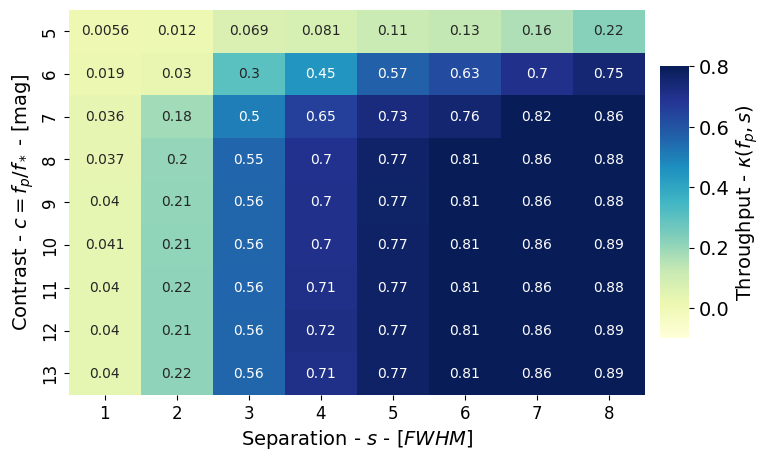

In [19]:
# 1. Create the plot layout ---------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(8, 5))

gs0 = fig.add_gridspec(1, 2, width_ratios = [1, 0.05])
gs0.update(wspace=0.05)

gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 1, subplot_spec = gs0[0], 
    hspace=0.12)
gs2 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec = gs0[1], 
    height_ratios=[0.1, 0.8, 0.1])

throughput_ax1 = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs2[1])

# 2. Plot the throughput table ------------------------------------
plot_throughput(throughput_ax1, throughput_results_1,
                color_bar=False)

throughput_ax1.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
throughput_ax1.set_xlabel(None)
throughput_ax1.tick_params(
    axis='both', which='major', labelsize=12)

# 3. Create the colorbar ------------------------------------------
cbar = throughput_ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
throughput_ax1.figure.axes[-1].yaxis.label.set_size(14)

# 4. Labels -------------------------------------------------------
throughput_ax1.set_ylabel(
    r"Contrast - $c = f_p / f_*$ - [mag]", size=14)
throughput_ax1.set_xlabel(
    r"Separation - $s$ - $\left[FWHM \right]$", size=14)

fig.patch.set_facecolor('white')
plt.savefig("./12_Throughput.pdf", bbox_inches='tight')